In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from descwl_shear_sims.galaxies import WLDeblendGalaxyCatalog
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.layout.layout import Layout

import anacal

from scipy.stats import linregress

As described in the "Getting the Simulation Input Data" section of the `descwl-shear-sims` README, run the following commands in the terminal in the same path as this notebook:

```
wget https://www.cosmo.bnl.gov/www/esheldon/data/catsim.tar.gz
tar xvfz catsim.tar.gz
```

Set the `catsim` path:

In [2]:
os.environ['CATSIM_DIR'] = 'catsim' 

We define some functions for extracting PSF arrays and generating images:

In [3]:
def get_psf_param(psf_obj, pixel_scale, psf_size):
    center_pos = (psf_size / 2.0, psf_size / 2.0)
    x_pixels = np.arange(psf_size)
    y_pixels = np.arange(psf_size)

    X, Y = np.meshgrid(x_pixels, y_pixels, indexing='ij')
    
    psf_image = psf_obj.drawImage(scale=pixel_scale, nx=psf_size, ny=psf_size)

    psf_array = psf_image.array
    
    return {
        'center_pos': center_pos,
        'coordinates': (X, Y),
        'psf_image': psf_array,
        'psf_object': psf_obj
    }

In [4]:
def generate_one_image_and_catalog(
        rng, psf, layout, shifts, g1, g2,
        select_observable, select_lower_limit, select_upper_limit, coadd_dim, buff, bands, 
        noise_factor, dither, dither_size, rotate, cosmic_rays, bad_columns,
    ):
    galaxy_catalog = WLDeblendGalaxyCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=buff,
        layout=layout,
        select_observable=select_observable,
        select_lower_limit=select_lower_limit,
        select_upper_limit=select_upper_limit
    )
    
    galaxy_catalog.shifts_array = shifts
    num = len(galaxy_catalog.shifts_array)
    galaxy_catalog.indices = galaxy_catalog.rng.randint(0, galaxy_catalog._wldeblend_cat.size,size=num)
    galaxy_catalog.angles = galaxy_catalog.rng.uniform(low=0, high=360, size=num)
    magnitude = galaxy_catalog._wldeblend_cat[galaxy_catalog.indices]["i_ab"]

    galaxy_catalog.shifts_array = shifts
    magnitude = []

    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=galaxy_catalog,
        coadd_dim=coadd_dim,
        g1=g1,
        g2=g2,
        bands=bands,
        psf=psf,
        noise_factor=noise_factor,
        dither=dither,
        dither_size=dither_size,
        rotate=rotate,
        cosmic_rays=cosmic_rays,
        bad_columns=bad_columns,
    )

    truth = sim_data['truth_info']
    image_x_positions = truth['image_x']
    image_y_positions = truth['image_y']

    x_pos_copy = np.array(image_x_positions, copy=True)
    y_pos_copy = np.array(image_y_positions, copy=True)
    
    positions_tensor = torch.stack([
        torch.from_numpy(x_pos_copy),
        torch.from_numpy(y_pos_copy)
    ], dim=1).float()
    
    M = len(image_x_positions)

    n_bands = len(bands)
    first_band = bands[0]
    h, w = sim_data['band_data'][first_band][0].image.array.shape
    
    image_tensor = torch.zeros(n_bands, h, w, dtype=torch.float32)
    
    for i, band in enumerate(bands):
        image_np = sim_data['band_data'][band][0].image.array
        image_tensor[i] = torch.from_numpy(image_np.copy())
    
    return image_tensor, positions_tensor, M, magnitude

In [5]:
def generate_many_images_and_catalogs(
        num_images, seed, layout_name, coadd_dim, buff, pixel_scale, density,
        select_observable, select_lower_limit, select_upper_limit,
        psf_type, psf_fwhm, bands, noise_factor, dither, dither_size, rotate,
        cosmic_rays, bad_columns, psf_size,
    ):
    
    print(f"Generating {num_images} images sequentially...")
    print(f"Bands: {bands}")
    print(f"Galaxy density: {density}")

    # Setup
    rng = np.random.RandomState(seed)
    
    # Sample shear1 and shear2 from Normal(0, 0.015^2)
    rng_shear = np.random.RandomState(seed + 1234)
    g1 = rng_shear.normal(0.0, 0.015, num_images).astype(np.float32)
    g2 = rng_shear.normal(0.0, 0.015, num_images).astype(np.float32)
    
    layout = Layout(
        layout_name=layout_name,
        coadd_dim=coadd_dim,
        pixel_scale=pixel_scale,
        buff=buff
    )
    shifts = layout.get_shifts(rng, density=density)
    
    psf = make_fixed_psf(psf_type=psf_type, psf_fwhm=psf_fwhm)
    
    # Storage for results
    n_bands = len(bands)
    images_tensor = torch.zeros(num_images, n_bands, 2048, 2048, dtype=torch.float32)
    catalogs = []
    psf_params = []
    
    # Generate images
    for i in tqdm(range(num_images), desc="Generating images"):
        image_tensor, positions_tensor, M, magnitude = generate_one_image_and_catalog(
            rng=rng, psf=psf, layout=layout, shifts=shifts, 
            g1=g1[i], g2=g2[i],
            select_observable=select_observable, select_lower_limit=select_lower_limit, select_upper_limit=select_upper_limit, 
            coadd_dim=coadd_dim, buff=buff, bands=bands, 
            noise_factor=noise_factor, dither=dither, dither_size=dither_size, rotate=rotate, 
            cosmic_rays=cosmic_rays, bad_columns=bad_columns,
        )
        
        crop_size = 2048
        if crop_size < image_tensor.shape[1]:
            H, W = image_tensor.shape[1], image_tensor.shape[2]
            start_h = (H - crop_size) // 2
            start_w = (W - crop_size) // 2
            image_tensor = image_tensor[:, start_h:start_h + crop_size, start_w:start_w + crop_size]

        images_tensor[i] = image_tensor
        catalogs.append({
            'positions': positions_tensor,
            'n_sources': M,
            'g1': g1[i],
            'g2': g2[i],
            'magnitude': magnitude
        })
        
        psf_param = get_psf_param(psf, pixel_scale=pixel_scale, psf_size=psf_size)
        psf_params.append(psf_param)
    
    print(f"Generated {num_images} images successfully")
    
    return images_tensor, catalogs, psf_params

We define our simulation settings and generate a batch of images:

In [6]:
num_images = 100
seed = 1234


psf_type = "moffat"          # "moffat" or "gauss"
psf_size = 64
psf_fwhm = 0.8              


pixel_scale = 0.2            # 0.2 is default
layout_name = 'random'       # 'random' or 'grid'
coadd_dim = 2550             # without rotation, image dim is coadd_dim + 1
buff = 0                     # 0 is default
bands = ['i']                # ['i'] is default
noise_factor = 1             # 0.58 is default
dither = False               # False is default
dither_size = 0.5            # 0.5 is default, but doesn't matter if dither = False
rotate = False               # False is default
cosmic_rays = False          # Set to True to add cosmic rays
bad_columns = False          # Set to True to add bad columns

density = 80                 # GALAXY density: per square arcmin, 80 is default  

catalog_type = 'wldeblend'   # 'wldeblend' or 'fixed'   
select_observable = 'i_ab'   # column name in the WLDEBlend catalog
select_lower_limit = None
select_upper_limit = 27

In [7]:
images, catalogs, psf_params = generate_many_images_and_catalogs(
    num_images=num_images, seed=seed, layout_name=layout_name, coadd_dim=coadd_dim, buff=buff, pixel_scale=pixel_scale, density=density,
    select_observable=select_observable, select_lower_limit=select_lower_limit, select_upper_limit=select_upper_limit,
    psf_type=psf_type, psf_fwhm=psf_fwhm, bands=bands, noise_factor=noise_factor, dither=dither, dither_size=dither_size, rotate=rotate,
    cosmic_rays=cosmic_rays, bad_columns=bad_columns, psf_size=psf_size
)

Generating 100 images sequentially...
Bands: ['i']
Galaxy density: 80


Generating images: 100%|██████████| 100/100 [10:59<00:00,  6.60s/it]

Generated 100 images successfully


If you'd like, you can uncomment the following lines to save the generated images, catalogs, and PSF parameters:

In [8]:
# torch.save(images, 'path_to_save/images.pt')
# torch.save(catalogs, 'path_to_save/catalogs.pt')
# torch.save(psf_params, 'path_to_save/psf_params.pt') 

Now we run AnaCal on each of the images generated above:

In [9]:
def convert_for_anacal(catalogs, psf_params):    
    g1_values = torch.tensor([cat['g1'] for cat in catalogs], dtype=torch.float32)
    g2_values = torch.tensor([cat['g2'] for cat in catalogs], dtype=torch.float32)
    
    anacal_catalog = {
        'shear_1': g1_values,
        'shear_2': g2_values,
    }
    
    anacal_psf = []
    for psf_param in psf_params:
        psf_image = psf_param['psf_image']
        if isinstance(psf_image, torch.Tensor):
            psf_image = psf_image.numpy()
        anacal_psf.append({'psf_image': psf_image.astype(np.float64)})
        
    return anacal_catalog, anacal_psf

In [10]:
def anacal_estimate(image, psf, catalog, npix):
    catalog, psf = convert_for_anacal(catalog, psf)
    true_shear1 = catalog['shear_1']
    true_shear2 = catalog['shear_2']

    fpfs_config = anacal.fpfs.FpfsConfig(
        npix=npix,
        sigma_arcsec=0.52,
    )

    mag_zero = 30.0
    pixel_scale = 0.2
    noise_variance = 0.23**2.0
    noise_array = None
    detection = None

    band = 0

    est_shear1 = torch.zeros(len(image))
    est_shear2 = torch.zeros(len(image))

    for i in range(len(image)):
        gal_array = image[i,band]
        psf_array = psf[i]['psf_image']

        out = anacal.fpfs.process_image(
            fpfs_config=fpfs_config,
            mag_zero=mag_zero,
            gal_array=gal_array,
            psf_array=psf_array,
            pixel_scale=pixel_scale,
            noise_variance=noise_variance,
            noise_array=noise_array,
            detection=detection,
        )

        e1 = out["fpfs_w"] * out["fpfs_e1"]
        e1g1 = out["fpfs_dw_dg1"] * out["fpfs_e1"] + out["fpfs_w"] * out["fpfs_de1_dg1"]

        est_shear1[i] = np.sum(e1) / np.sum(e1g1)

        e2 = out["fpfs_w"] * out["fpfs_e2"]
        e2g2 = out["fpfs_dw_dg2"] * out["fpfs_e2"] + out["fpfs_w"] * out["fpfs_de2_dg2"]
        
        est_shear2[i] = np.sum(e2) / np.sum(e2g2)

    return est_shear1, est_shear2, true_shear1, true_shear2

In [11]:
est_shear1, est_shear2, true_shear1, true_shear2 = anacal_estimate(images, psf_params, catalogs, 64)

We plot the true vs. estimated shear1 and shear2:

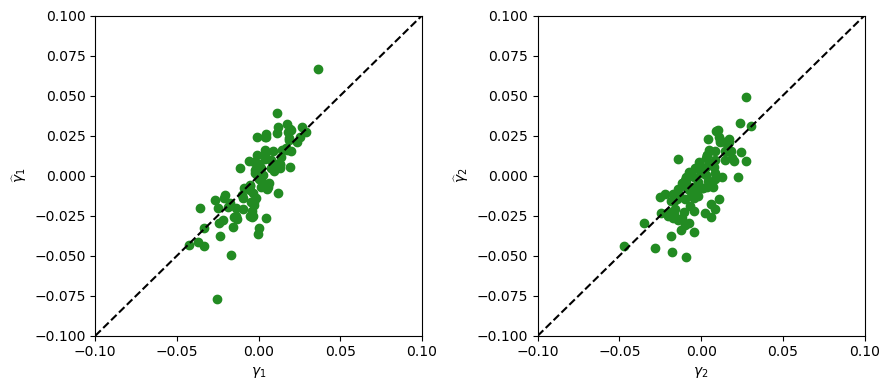

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (9, 4))

_ = ax[0].scatter(true_shear1, est_shear1, color = 'forestgreen')
_ = ax[0].axline((0,0), slope = 1, linestyle = 'dashed', color = 'black')
_ = ax[0].set_xlabel("$\gamma_1$")
_ = ax[0].set_ylabel("$\widehat{\gamma}_1$")
_ = ax[0].set_xlim(-0.1, 0.1)
_ = ax[0].set_ylim(-0.1, 0.1)

_ = ax[1].scatter(true_shear2, est_shear2, color = 'forestgreen')
_ = ax[1].axline((0,0), slope = 1, linestyle = 'dashed', color = 'black')
_ = ax[1].set_xlabel("$\gamma_2$")
_ = ax[1].set_ylabel("$\widehat{\gamma}_2$")
_ = ax[1].set_xlim(-0.1, 0.1)
_ = ax[1].set_ylim(-0.1, 0.1)

_ = fig.tight_layout()

Finally, we estimate the additive and multiplicative biases of our shear estimates:

In [13]:
lr1 = linregress(true_shear1.flatten().cpu().numpy(), est_shear1.flatten().cpu().numpy())
lr2 = linregress(true_shear2.flatten().cpu().numpy(), est_shear2.flatten().cpu().numpy())

print(f"Shear 1:\nc ± 3SE = {lr1.intercept:.6f} ± {3 * lr1.intercept_stderr:.6f}, m ± 3SE = {lr1.slope - 1:.6f} ± {3*lr1.stderr}\n")
print(f"Shear 2:\nc ± 3SE = {lr2.intercept:.6f} ± {3 * lr2.intercept_stderr:.6f}, m ± 3SE = {lr2.slope - 1:.6f} ± {3*lr2.stderr}")

Shear 1:
c ± 3SE = -0.002430 ± 0.004560, m ± 3SE = 0.322434 ± 0.282602260957017

Shear 2:
c ± 3SE = -0.001496 ± 0.007010, m ± 3SE = -0.062331 ± 0.4868020708998585
